## Business + Data Understanding

Gather necessary data to answer your questions

Handle categorical and missing data

Provide insight into the methods you chose and why you chose them

In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict
import datetime  
from datetime import date, timedelta, datetime
import mplleaflet
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline


In [ ]:
listing_df = pd.read_csv('./listings_seattle.csv')
calendar_df = pd.read_csv('./calendar_seattle.csv')
reviews_df = pd.read_csv('./reviews_seattle.csv')

### Understanding the data

Starting with the listing_df file, we will look into its parameters and try to understand the data.

In [244]:
rows = listing_df.shape[0]
cols = listing_df.shape[1]

In [245]:
name_cols = listing_df.columns

In [246]:
cat_df = listing_df.select_dtypes(include=['object'])

In [3]:
#I created groups of columns with relevant information about a certain aspect of AirBnB's listings
#General Information
gen_cols = ['id', 'name']

#Text Description
text_cols = ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit']

#Host Info
host_cols = ['host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified']

#Location Info
loc_cols = ['street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 
       'smart_location', 'latitude', 'longitude',
       'is_location_exact']

#Apartment Info
apt_cols = ['property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']

#Price Info
price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people']

#Availability
aval_cols = ['minimum_nights', 'maximum_nights', 'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90',
       'availability_365']

#Reviews - Satisfaction
rev_cols = ['number_of_reviews', 
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']

#Booking
book_cols = ['instant_bookable', 'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification']


### Plotting the data

Helps visualizing and understanding the information. To understand which percentage of values falls into a certain category, I used bar plots and the relative frequency of each data point.

C:\Users\tatheoto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


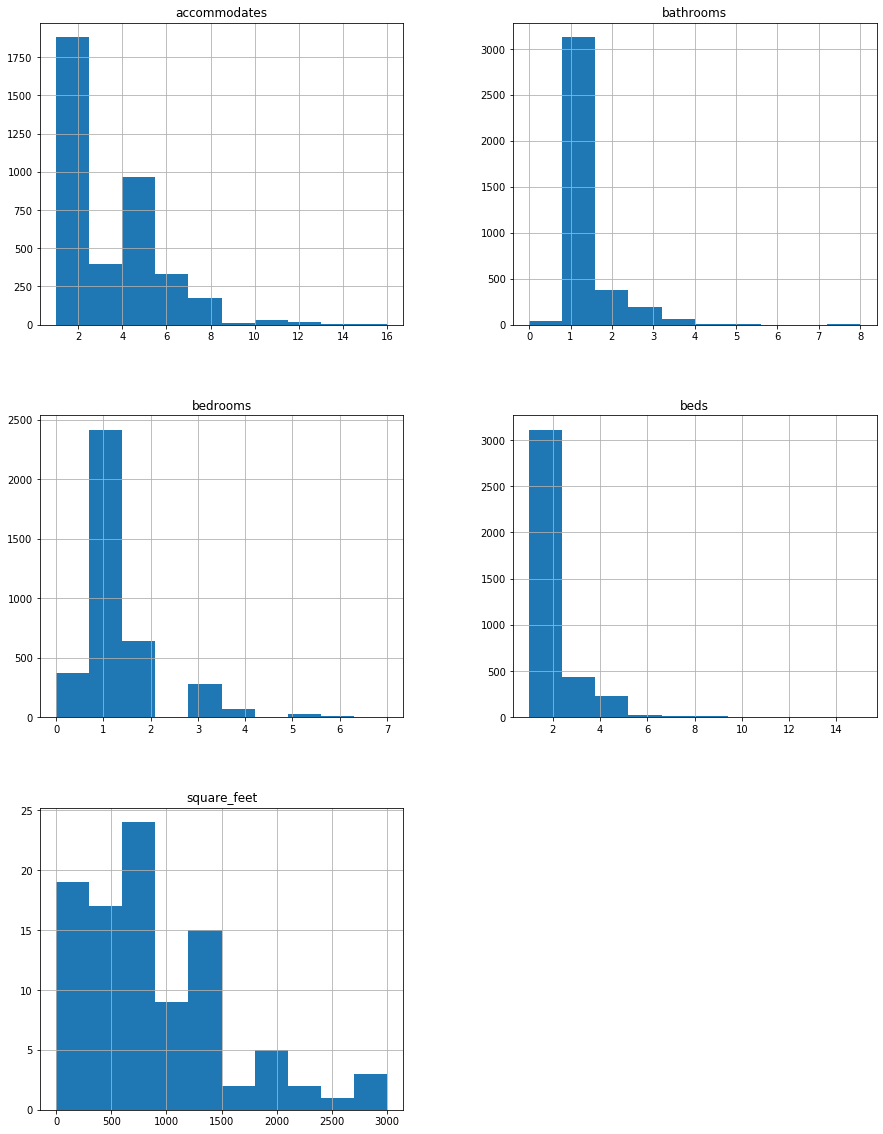

In [248]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
listing_df[apt_cols].hist(ax = ax);

In [205]:
def get_prop(df, col, sort='value'):
    if sort == 'value':
        return (df[col].value_counts().sort_values()/(df.shape[0]-sum(df[col].isnull())))
    elif sort == 'index':
        return (df[col].value_counts().sort_index()/(df.shape[0]-sum(df[col].isnull())))

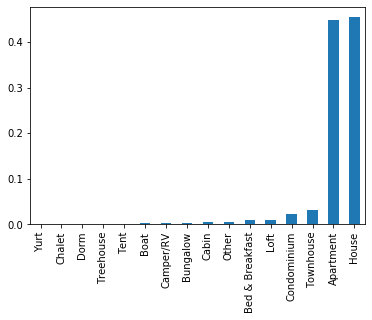

In [207]:
get_prop(listing_df, 'property_type').plot(kind='bar');

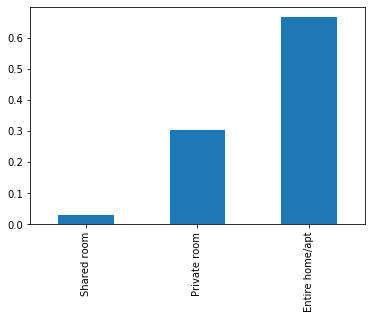

In [146]:
get_prop(listing_df, 'room_type').plot(kind='bar');

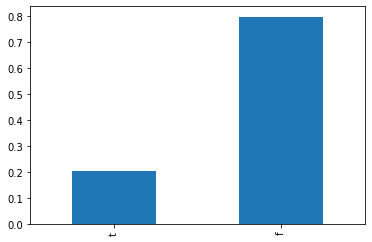

In [208]:
get_prop(listing_df, 'host_is_superhost').plot(kind='bar');

### Cleaning the data

First I will locate which columns can be deleted (i.e., with a single value). Then, I will analyse which columns have the highest percentage of missing values.

In [4]:
#Identifying and dropping columns with only one value

uni_cols = []

for col in listing_df.columns:
    if len(listing_df[col].unique()) == 1:
        uni_cols.append(col)
        listing_df = listing_df.drop(columns=[col])

In [5]:
#Checking for columns with > 25% missing values

for col in listing_df.columns:
    if listing_df[col].isnull().mean() > 0.25:
        print("The column {} has {:.1f}% of missing values".format(col , 100*listing_df[col].isnull().mean()))

The column neighborhood_overview has 27.0% of missing values
The column notes has 42.1% of missing values
The column square_feet has 97.5% of missing values
The column weekly_price has 47.4% of missing values
The column monthly_price has 60.3% of missing values
The column security_deposit has 51.1% of missing values
The column cleaning_fee has 27.0% of missing values


The price data is saved as a string. The next cells transform the relevant data points into floats.

In [6]:
#function was needed in order to try/except values; np.nan values cannot be transformed into float
def clean_price(x):
    try:
        return float(x.replace('$', '').replace(',', ''))
    except:
        return x

In [7]:
for col in price_cols:
    listing_df[col] = listing_df[col].apply(lambda x: clean_price(x))

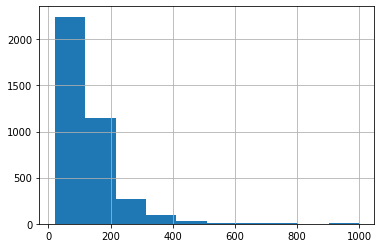

In [8]:
listing_df['price'].hist(bins=10);

The host_response_rate is also saved as a percentage string. We will also change it to numbers.

In [9]:
def clean_perc(x):
    try:
        return float(x.replace('%', ''))/100
    except:
        return x
    
listing_df['host_response_rate'] = listing_df['host_response_rate'].apply(lambda x: clean_perc(x))

Now it's time to clean multiple selection columns.

In [10]:
#Finding all possible values in a column with multiple value selection

find_unique = lambda x: x.replace("[", '').replace("]", '').replace(",", '')

unique_vals = list(set(listing_df['host_verifications'].apply(find_unique).str.cat(sep=' ').split(' ')))

In [257]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    for val in look_for:
        for row in range(df.shape[0]):
            if val in df[col1][row]:
                new_df[val] += int(df[col2][row])

    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values(col2, ascending=False, inplace=True)
    return new_df

In [258]:
possible_vals = unique_vals

def clean_and_plot(df, col, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df[col].value_counts().reset_index()
    study_df = total_count(study, 'index', col, possible_vals)
    study_df.set_index('index', inplace=True)
    
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df

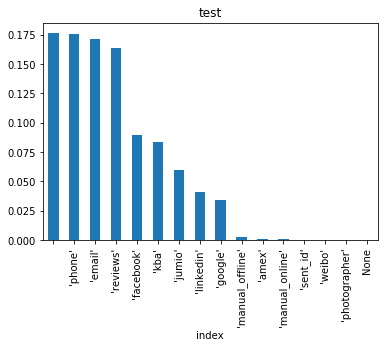

,host_verifications
index,
,0.176408
'phone',0.175161
'email',0.171233
'reviews',0.163979
'facebook',0.089082
'kba',0.083907
'jumio',0.059557
'linkedin',0.041168
'google',0.034422


In [259]:
clean_and_plot(listing_df, 'host_verifications', 'test')

In [260]:
listing_df.groupby('host_response_time').mean()['review_scores_rating']

host_response_time
a few days or more    87.793103
within a day          94.264831
within a few hours    93.812425
within an hour        95.143984
Name: review_scores_rating, dtype: float64

In [161]:
listing_df.groupby('host_response_rate').mean()['review_scores_rating']

host_response_rate
0.17    100.000000
0.25     97.500000
0.30    100.000000
0.31     97.000000
0.33     90.818182
0.38    100.000000
0.40     73.142857
0.43     85.750000
0.50     94.257143
0.53     94.000000
0.55           NaN
0.56    100.000000
0.57     81.000000
0.58     92.000000
0.60     94.588235
0.63     95.777778
0.64     91.666667
0.65    100.000000
0.67     93.129032
0.68           NaN
0.69     85.000000
0.70     90.954545
0.71     85.250000
0.75     94.413793
0.76     95.333333
0.78     94.333333
0.80     88.870968
0.81     94.000000
0.82     92.500000
0.83     94.750000
0.86     92.703704
0.87     93.333333
0.88     93.529412
0.89     92.448276
0.90     93.527027
0.91     96.000000
0.92     92.000000
0.93     93.941176
0.94     94.195122
0.95     97.857143
0.96     92.058824
0.97     91.000000
0.98     93.678571
0.99     92.306452
1.00     95.277885
Name: review_scores_rating, dtype: float64

In [163]:
listing_df.groupby('host_is_superhost').mean()['review_scores_rating']

host_is_superhost
f    93.652893
t    97.395473
Name: review_scores_rating, dtype: float64

In [164]:
listing_df.groupby('host_listings_count').mean()['review_scores_rating']

host_listings_count
1.0      95.279748
2.0      94.233273
3.0      94.938865
4.0      93.983740
5.0      93.988235
6.0      94.179487
7.0      90.826087
8.0      92.227273
9.0      93.814815
10.0     94.826087
11.0     87.666667
12.0     95.714286
13.0     97.750000
15.0     91.333333
17.0     87.300000
18.0     92.526316
19.0     80.000000
21.0     92.761905
34.0     86.338462
36.0     92.931034
37.0     89.857143
48.0     97.121951
84.0     91.500000
163.0    97.500000
169.0    93.648649
354.0    90.000000
502.0    67.500000
Name: review_scores_rating, dtype: float64

In [165]:
listing_df.groupby('host_identity_verified').mean()['review_scores_rating']

host_identity_verified
f    93.346760
t    94.801154
Name: review_scores_rating, dtype: float64

In [167]:
listing_df.groupby('host_has_profile_pic').mean()['review_scores_rating']

host_has_profile_pic
f    97.800000
t    94.534112
Name: review_scores_rating, dtype: float64

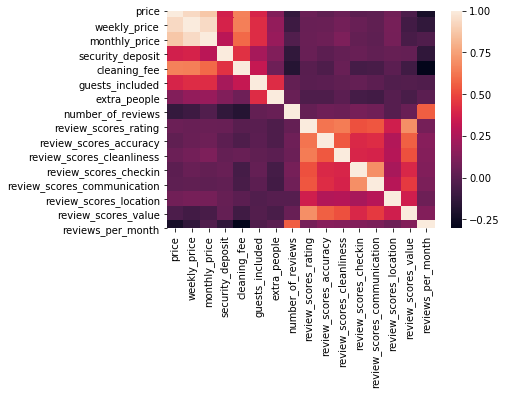

In [96]:
test_df = listing_df[price_cols + rev_cols]
sns.heatmap(test_df.corr());

Size & Price

In [168]:
apt_cols

['property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet']

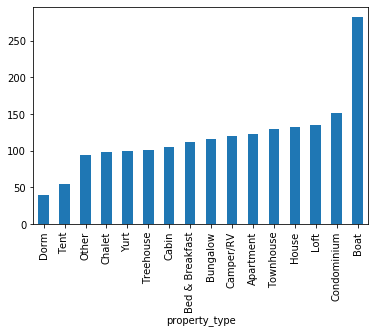

In [176]:
listing_df.groupby('property_type').mean()['price'].sort_values().plot(kind='bar');

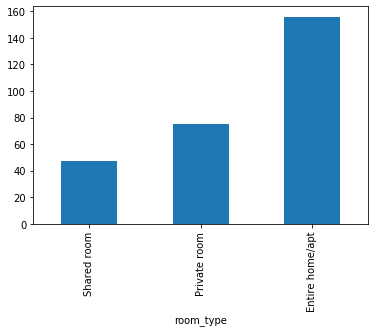

In [177]:
listing_df.groupby('room_type').mean()['price'].sort_values().plot(kind='bar');

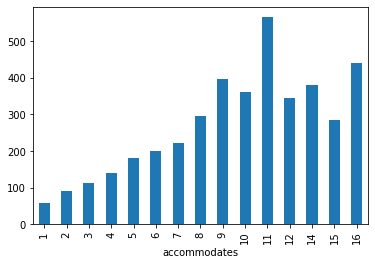

In [180]:
listing_df.groupby('accommodates').mean()['price'].plot(kind='bar');

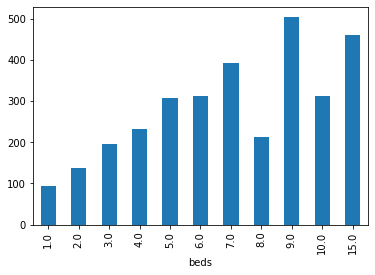

In [182]:
listing_df.groupby('beds').mean()['price'].plot(kind='bar');

### Questions

- How to be a great AirBnB host? Do certain host characteristics relate to better reviews? 
- Are Superhosts more sucessful? 
- Where are the most expensive properties located? Does that reflects the current real state prices of the neighbourhood?
- What influences price?
- Are most expensive listings actually better reviewed?
- How does price fluctuate through the year?
- How is price distributed? How do two cities compare?
- Which words are most common in reviews?
- How do ammenities affect the price?
- Which neighbourhoods have the most expensive listings?

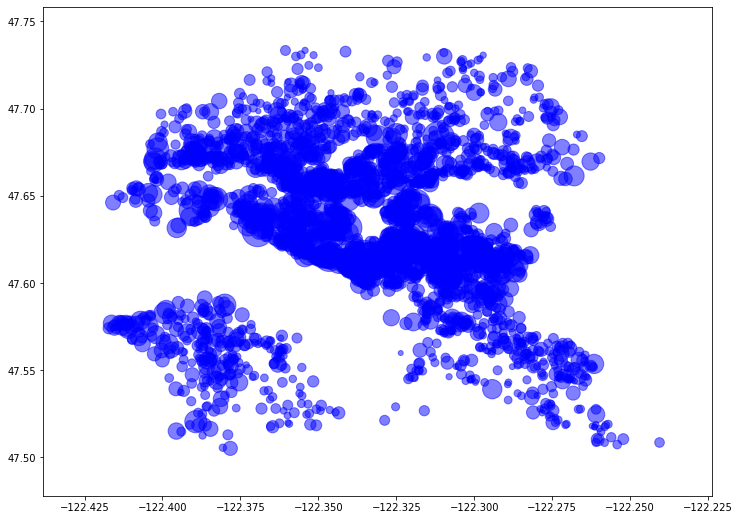

In [267]:
#change size to colormapping
line_plot_fig, line_plot_ax = plt.subplots(figsize=(12,9))
line_plot_ax.scatter(listing_df['longitude'], listing_df['latitude'], s= listing_df['price'], c= "Blue", alpha=0.5);

### How does availability and price fluctuate through the year?

In [21]:
#Cleaning calendar data
calendar_df = pd.read_csv('./calendar_seattle.csv')
#price from string to float
calendar_df['price'] = calendar_df['price'].apply(lambda x: clean_price(x))
#available from string to int (1 if t, 0 if f)
calendar_df['available'] = pd.get_dummies(calendar_df['available'], drop_first=True)

In [81]:
#Converting strings to dates
calendar_df['date'] = (calendar_df['date'].apply(datetime.strptime, args=('%Y-%m-%d',)))

In [95]:
#mean availability per listing
avai_list = calendar_df.groupby('listing_id').mean()['available']

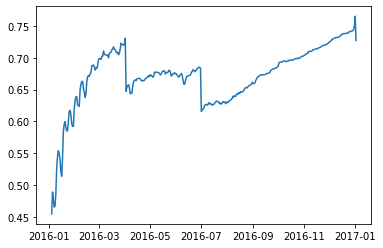

In [98]:
#changes over time on availability
time_df = calendar_df.groupby('date').mean().reset_index()

plt.plot(time_df['date'], time_df['available']);

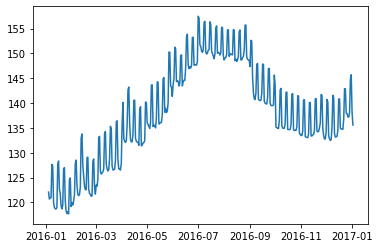

In [99]:
#Seattle beer fest, pride, 4th of July and seafair https://www.tripsavvy.com/seattle-summer-festivals-2964736
plt.plot(time_df['date'], time_df['price']);

### Are Superhosts more sucessful? 

As an AirBnB client, I have asked myself: what characterizes a "Superhost"? For me, the category was a synonym of better quality, as a "stamp of approval" from AirBnB itself, but also higher prices.

Based on the Seattle AirBnB data, I would like to know - are "Superhosts" actually better reviewed? And does the "Superhost" Badge mean higher prices? Let's find out!

In [468]:
# Total price column:
# price/night + security deposit (if any) + cleaning fee (if any)

listing_df['total_price'] = (listing_df['price']
                            + listing_df['security_deposit'].fillna(0) 
                            + listing_df['cleaning_fee'].fillna(0))

In [356]:
# Dataframe for superhosts:

super_df = listing_df[listing_df['host_is_superhost'] == 't']

# Dataframe for regular hosts:

reg_df = listing_df[listing_df['host_is_superhost'] == 'f']

#### Reviews: Superhost vs. Regular Hosts

In [497]:
# Relevant Review Columns in Listings_df:

rev_cols = ['number_of_reviews', 'first_review', 'last_review', 
            'review_scores_rating', 'review_scores_accuracy', 
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location', 
            'review_scores_value', 'reviews_per_month']

# Superhost Review Data:

super_reviews = super_df[rev_cols]

# Superhost Average Review Parameters:

super_rev_mean = pd.DataFrame(super_reviews.mean(), columns = ['mean_value'])

# Regular host Review Data:

reg_reviews = reg_df[rev_cols]

# Regular host Average Review Parameters:

reg_rev_mean = pd.DataFrame(reg_reviews.mean(), columns = ['mean_value'])

In [510]:
# Analyzing missing reviews:

# Superhosts:

print("{:.1f}% of Superhost Listings are yet to be reviewed"
      .format(100*super_reviews['review_scores_rating'].isnull().mean()))

# Regular hosts:

print("{:.1f}% of Regular Listings are yet to be reviewed"
      .format(100*reg_reviews['review_scores_rating'].isnull().mean()))

3.5% of Superhost Listings are yet to be reviewed
20.3% of Regular Listings are yet to be reviewed


In [499]:
# Comparison between Average Review Parameters:

comp_df = pd.merge(super_rev_mean, reg_rev_mean, left_index=True, right_index=True)
comp_df.columns = ['Superhosts', 'Regular Hosts']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']

# Conclusions:

print('One observes that Superhosts receive on average twice as much reviews as their regular counterparts '
      '- maybe because they are more often booked. The ratings are marginally higher for Superhosts on average.')

# Show Results:

comp_df.round(1).style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

One observes that Superhosts receive on average twice as much reviews as their regular counterparts - maybe because they are more often booked. The ratings are marginally higher for Superhosts on average.


,Superhosts,Regular Hosts,Delta
number_of_reviews,41.8,17.2,24.5
review_scores_rating,97.4,93.7,3.7
review_scores_accuracy,9.9,9.6,0.4
review_scores_cleanliness,9.9,9.5,0.4
review_scores_checkin,10,9.7,0.2
review_scores_communication,10,9.8,0.2
review_scores_location,9.8,9.6,0.2
review_scores_value,9.7,9.4,0.4
reviews_per_month,3,1.8,1.2


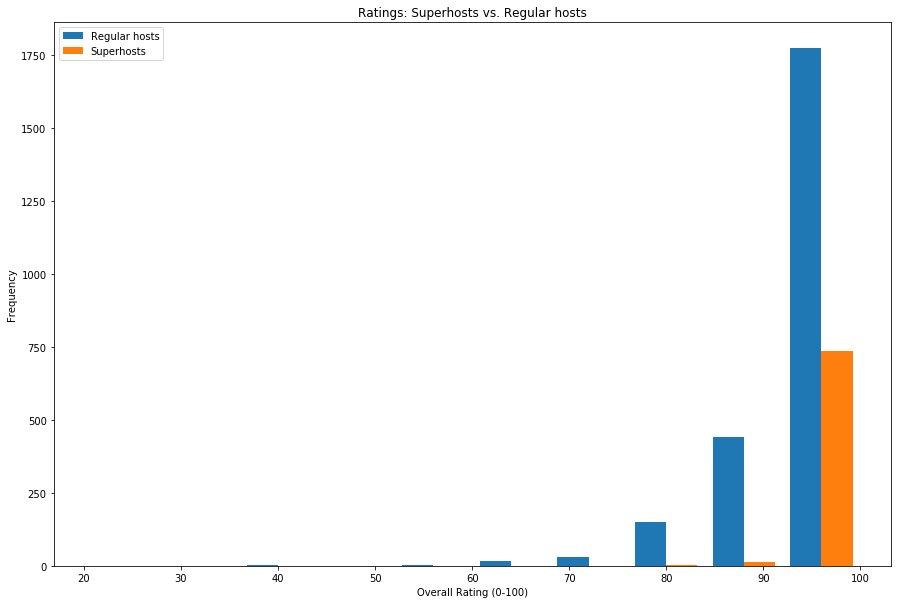

In [516]:
# Rating Scores Histogram - Absolute Frequency

fig = plt.figure(figsize = (15,10))
plt.hist([reg_reviews['review_scores_rating'], super_reviews['review_scores_rating']]);

# Legends and Axis Labels

plt.legend(['Regular hosts', 'Superhosts']);
plt.ylabel('Frequency');
plt.xlabel('Overall Rating (0-100)');
plt.title('Ratings: Superhosts vs. Regular hosts');

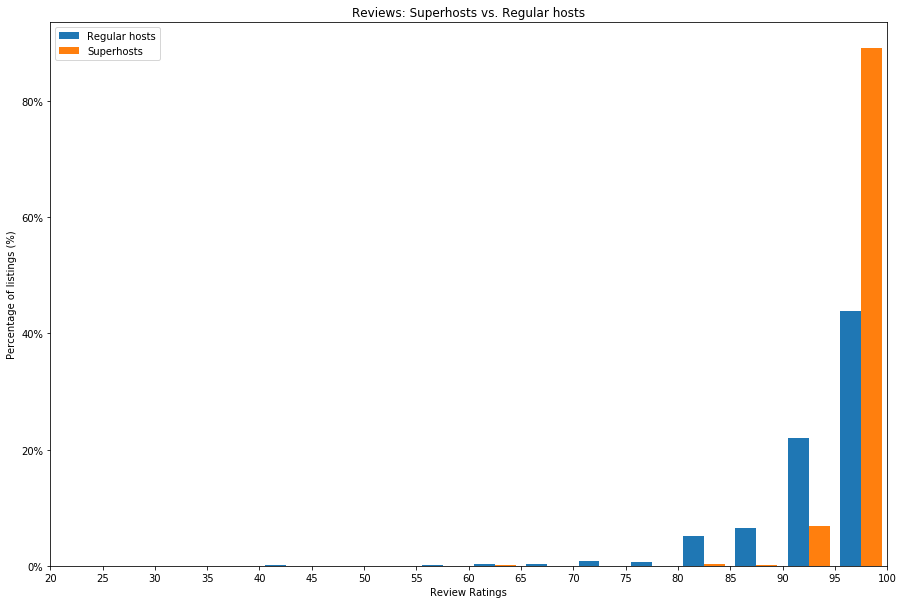

In [569]:
# Rating Scores Histogram - Relative Frequency

# We want to analyze the percentage of listings with a certain rating,
# therefore our basis will include missing values: 

super_scores = super_reviews['review_scores_rating']
reg_scores = reg_reviews['review_scores_rating']

# Defining bin size to optimize visualization
# Distribution is starkly negatively skewed - almost every value is between 80 and 100
# Thus the smaller bin size

bin_size = list(range(0, int(super_scores.max()) + 1, 5))

# Defining weights for each distribution
# that is, the basis for the percentage

basis_super = np.ones(len(super_scores)) / len(super_scores)
basis_reg = np.ones(len(reg_scores)) / len(reg_scores)

# Plotting the histogram

fig = plt.figure(figsize = (15, 10))
plt.hist([reg_scores, super_scores], weights = [basis_reg, basis_super], bins=bin_size)

# Formatting percentages, legends and axis labels

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(['Regular hosts', 'Superhosts']);
plt.ylabel('Percentage of listings (%)');
plt.xlabel('Review Ratings');
plt.xticks(bin_size);
plt.xlim((min(min(reg_scores), min(super_scores)),100));
plt.title('Reviews: Superhosts vs. Regular hosts');

# Uncomment the next two lines for a zoom in into the worst reviews

plt.xlim((0,max(min(reg_scores),min(super_scores)));
# plt.ylim((0, 0.02));

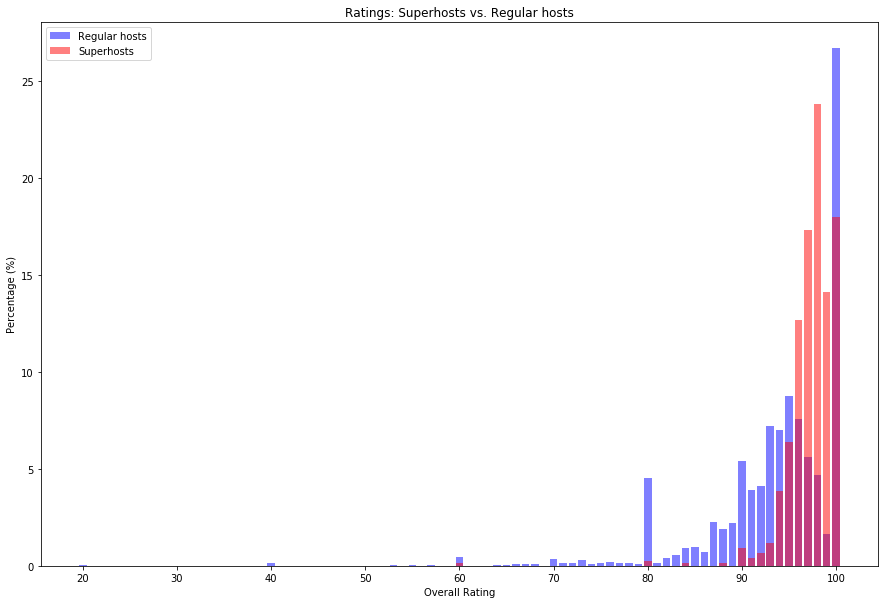

In [427]:
super_plot = get_prop(super_reviews, 'review_scores_rating', 'index')
reg_plot = get_prop(reg_reviews, 'review_scores_rating', 'index')

fig = plt.figure(figsize = (15,10))
plt.bar(reg_plot.index, reg_plot.values*100, color='b', alpha = 0.5);
plt.bar(super_plot.index, super_plot.values*100, color='red', alpha = 0.5);

plt.legend([reg_p, super_p],['Regular hosts', 'Superhosts']);
plt.ylabel('Percentage (%)');
plt.xlabel('Overall Rating');
plt.title('Ratings: Superhosts vs. Regular hosts');

In [335]:
super_price = pd.DataFrame(super_df[price_cols].mean(), columns = ['value'])
reg_price = pd.DataFrame(reg_df[price_cols].mean(), columns = ['value'])
comp_df = pd.merge(super_price, reg_price, left_index=True, right_index=True)
comp_df.columns = ['Superhosts', 'Regular Hosts']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']
comp_df.style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

,Superhosts,Regular Hosts,Delta
price,130.14,127.391,2.74873
weekly_price,824.321,777.66,46.6605
monthly_price,2980.99,2495.47,485.52
security_deposit,280.445,289.941,-9.49564
cleaning_fee,58.0924,62.7567,-4.6643
guests_included,1.82905,1.63298,0.196067
extra_people,12.126,10.293,1.83301


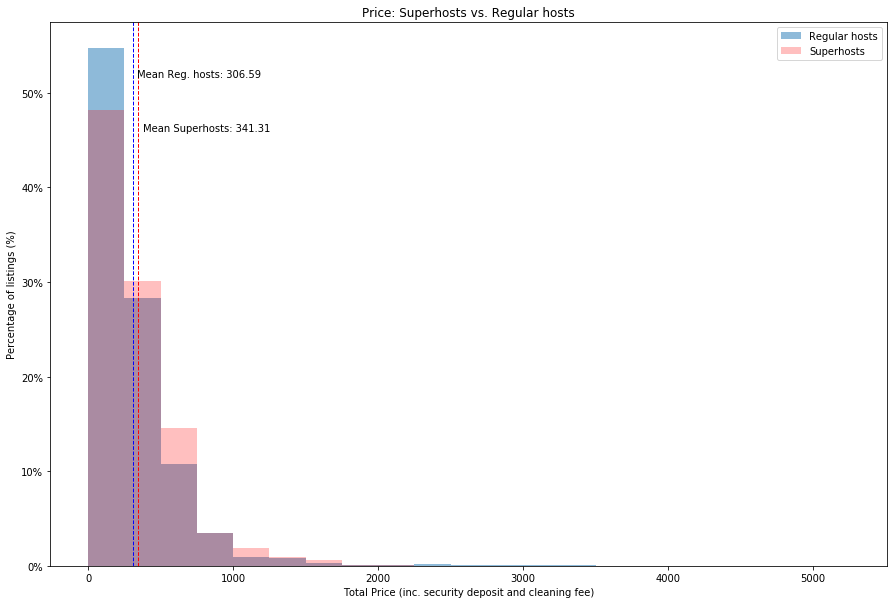

In [461]:
#Creating histograms with the percentage of listings in a certain price range
bin_size = list(range(0, int(max(reg_df['total_price'])) + 1,250))
fig = plt.figure(figsize = (15,10))
plt.hist([reg_df['total_price']], weights=np.ones(len(reg_df['total_price'])) / len(reg_df['total_price']), alpha = 0.5, bins = bin_size)
plt.hist([super_df['total_price']], weights=np.ones(len(super_df['total_price'])) / len(super_df['total_price']), alpha = 0.25, color= 'r', bins = bin_size)

# plt.xlim((-100,2000))
plt.legend(['Regular hosts', 'Superhosts']);

plt.axvline(reg_df['total_price'].mean(), color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(reg_df['total_price'].mean()*1.1, max_ylim*0.9, 'Mean Reg. hosts: {:.2f}'.format(reg_df['total_price'].mean()))

plt.axvline(super_df['total_price'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.text(super_df['total_price'].mean()*1.1, max_ylim*0.8, 'Mean Superhosts: {:.2f}'.format(super_df['total_price'].mean()))


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of listings (%)');
plt.xlabel('Total Price (inc. security deposit and cleaning fee)');
plt.title('Price: Superhosts vs. Regular hosts');

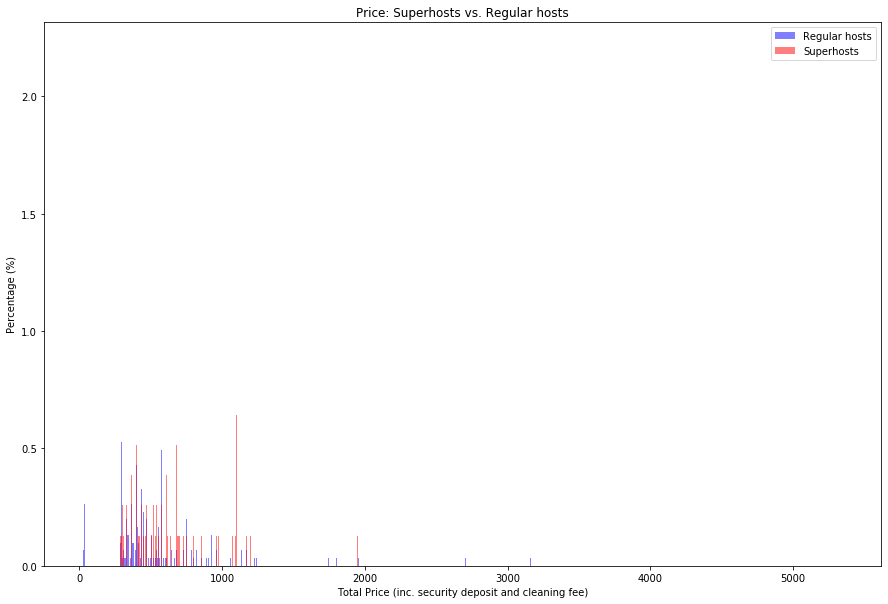

In [357]:
super_plot = get_prop(super_df, 'total_price', 'index')
reg_plot = get_prop(reg_df, 'total_price', 'index')

fig = plt.figure(figsize = (15,10))
plt.bar(reg_plot.index, reg_plot.values*100, color='b', alpha = 0.5);
plt.bar(super_plot.index, super_plot.values*100, color='red', alpha = 0.5);

plt.legend([reg_p, super_p],['Regular hosts', 'Superhosts']);
plt.ylabel('Percentage (%)');
plt.xlabel('Total Price (inc. security deposit and cleaning fee)');
plt.title('Price: Superhosts vs. Regular hosts');

In [322]:
grades_reg = list(reg_plot.index)
grades_sup = list(super_plot.index)
missing_sup = [x for x in grades_reg if x not in grades_sup]
# missing_reg = [x for x in grades_sup if x not in grades_reg]

In [323]:
for grade in missing_sup:
    super_plot = super_plot.append(pd.Series([0], index=[grade]))
super_plot = super_plot.sort_index()

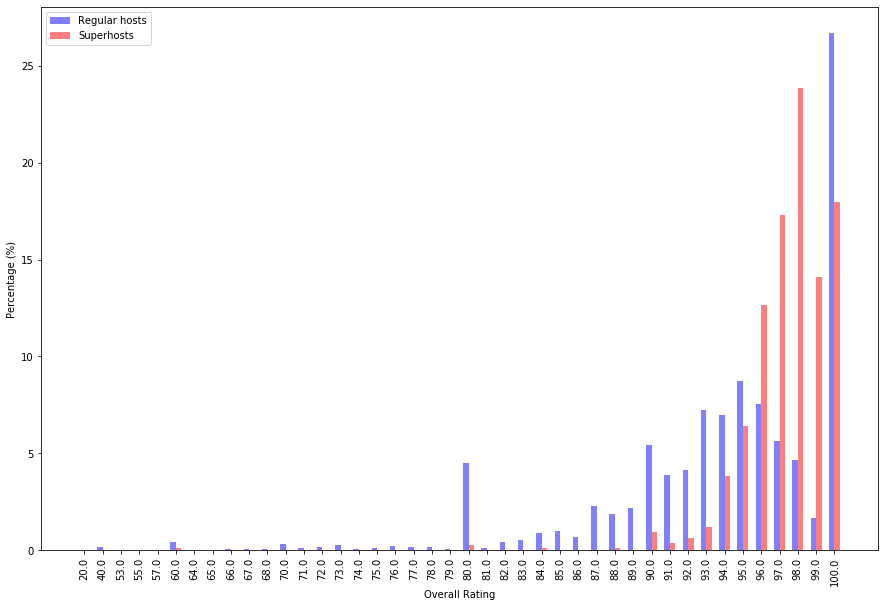

In [330]:
fig = plt.figure(figsize = (15,10))
x = np.arange(len(reg_plot.index))
ax1 = plt.subplot(1,1,1)
w = 0.3
plt.xticks(x + w /2, reg_plot.index, rotation='vertical');
reg_p =ax1.bar(x, reg_plot.values*100, width=w, color='b', alpha=0.5, align='center')
super_p =ax1.bar(x + w, super_plot.values*100, width=w,color='r', alpha=0.5, align='center')
plt.legend([reg_p, super_p],['Regular hosts', 'Superhosts']);
plt.ylabel('Percentage (%)');
plt.xlabel('Overall Rating');
